## Denoiser evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader
from yass.augment.util import amplitudes

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model

Using TensorFlow backend.


In [3]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [4]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

In [19]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

rec = RecordingsReader(path_to_standarized, loader='array').data

(spatial_sig,
 temporal_sig) = noise_utils.noise_cov(rec, 61, 61)

# spatial_sig.shape, temporal_sig.shape

In [20]:
spatial_sig.shape, temporal_sig.shape

((49, 49), (61, 61))

## Load model

In [21]:
model = load_model('/tmp/denoiser.h5')

## Evaluation on test set

## Template loading

In [22]:
uncropped = np.load(Path('~', 'data', 'cat', 'templates-jul27-only-good.npy').expanduser())

In [23]:
templates_raw = TemplatesProcessor(uncropped).values
templates_raw = templates_raw[np.argsort(augment_util.amplitudes(templates_raw))]
templates_raw.shape

(240, 61, 49)

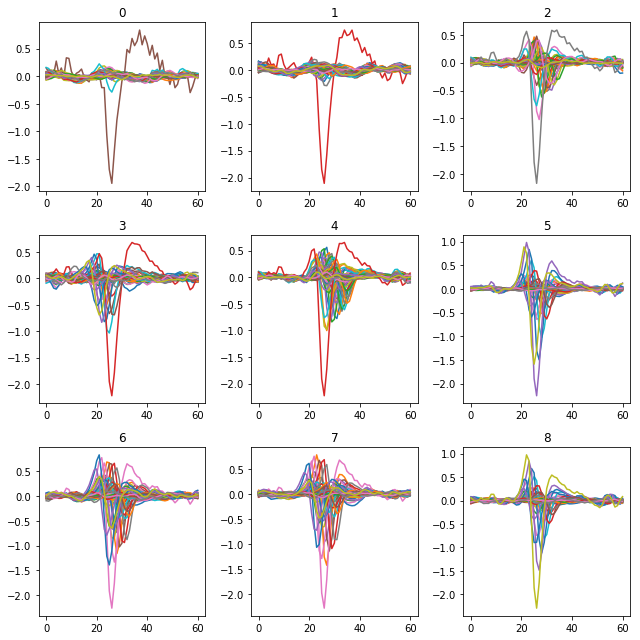

In [24]:
# should i use this small templates?
plot.grid_from_array(templates_raw, axis=0, elements=range(9), auto_figsize=3)

In [25]:
# add noise
templates_noisy, _ = augment_util.add_noise(templates_raw,
                                            spatial_sig, temporal_sig,
                                            reject_cancelling_noise=False)
print(templates_noisy.shape)

(240, 61, 49)


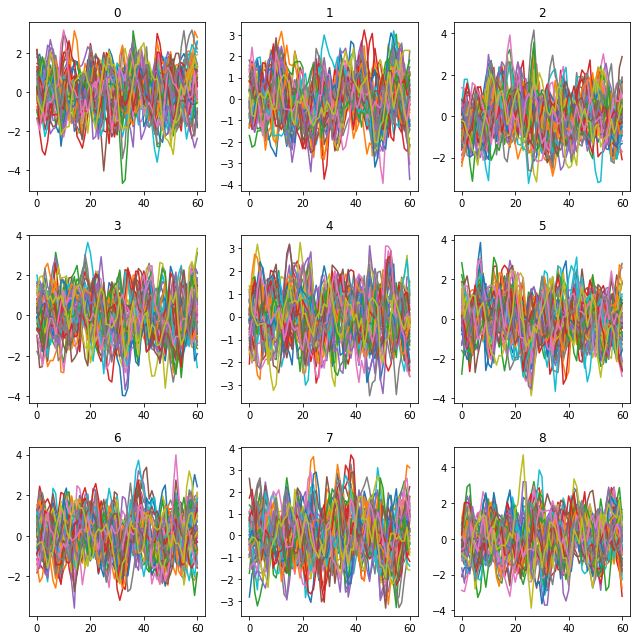

In [26]:
plot.grid_from_array(templates_noisy, axis=0, elements=range(9), auto_figsize=3)

## Denoise templates

## Denoise the same input many times

## Generate testing data

In [31]:
min_amp = 5
max_amp = 10
n_clean_per_template = 20

In [32]:
dataset = Dataset.make(units_per_bin=0.5,
                       include_clean_data=True,
                       templates=templates_raw,
                       min_amplitude=min_amp,
                       max_amplitude=max_amp,
                       n_per_template=n_clean_per_template,
                       spatial_sig=spatial_sig,
                       temporal_sig=temporal_sig,
                       make_from_templates=True,
                       make_spatially_misaligned=False,
                       make_temporally_misaligned=False,
                       make_collided=False,
                       make_noise=False,
                       add_noise_kwargs={'reject_cancelling_noise': True})

In [33]:
dataset.stats

{'from templates': 2962}

In [34]:
def sort_data(data):
    amps = amplitudes(data)
    print(amps.min(), amps.max())
    return data[np.argsort(amps)]

In [35]:
IDX = 0
to_denoise = dataset.data_clean[[IDX], :, :]
print(to_denoise.shape)
to_denoise_repeated = np.repeat(to_denoise, repeats=10, axis=0)
print(to_denoise_repeated.shape)
to_denoise_repeated, _ = augment_util.add_noise(to_denoise_repeated, spatial_sig, temporal_sig)
print(to_denoise_repeated.shape)

(1, 61, 49)
(10, 61, 49)
(10, 61, 49)


In [37]:
def denoise(model, to_denoise):
    input_shape = model.input_shape[1]
    snippet_length = to_denoise.shape[0]
    half_input_shape = int((input_shape - 1)/2)
    out_shape = (snippet_length - half_input_shape * 2, to_denoise.shape[1])

    idx_start = half_input_shape
    idx_end = snippet_length - half_input_shape - 1

    slices = [slice(idx-half_input_shape, idx+half_input_shape+1) for idx in range(idx_start, idx_end + 1)]

    out = np.empty(out_shape)

    to_denoise_extra = np.zeros((to_denoise.shape[0], to_denoise.shape[1]+1))
    to_denoise_extra[:, :-1] = to_denoise

    for ch, waveform in enumerate(to_denoise.T):
        for i, s in enumerate(slices):
            neighbors = ch_idx[ch]
            input_wf = to_denoise_extra[np.newaxis, s, neighbors, np.newaxis]
            out[i, ch] = model.predict(input_wf)

    wf, _ = to_denoise.shape
    middle = int((wf  - 1) / 2)
    half_window = int((out_shape[0] - 1) / 2)
    orig = to_denoise[middle-half_window:middle+half_window+1, :]

    return out, orig

In [38]:
to_denoise_repeated.shape

(10, 61, 49)

In [39]:
out = np.empty((to_denoise_repeated.shape[0], 41, to_denoise_repeated.shape[2]))

for i, to_denoise in enumerate(to_denoise_repeated):
    out_single, _ = denoise(model, to_denoise)
    out[i, :, :] = out_single

In [40]:
out.shape

(10, 41, 49)

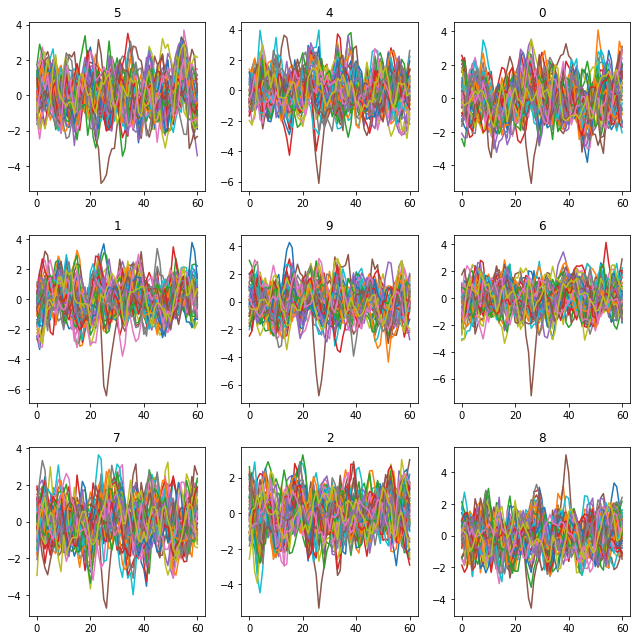

In [46]:
plot.grid_from_array(to_denoise_repeated, axis=0, auto_figsize=3, elements=9)

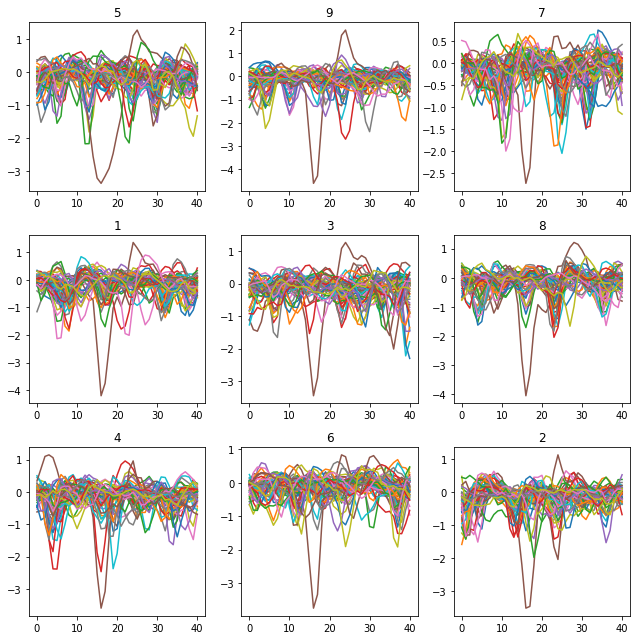

In [47]:
plot.grid_from_array(out, axis=0, auto_figsize=3, elements=9)

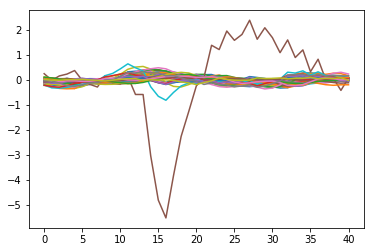

In [48]:
middle = 30
half_window = 20
truth = dataset.data_clean[IDX][middle-half_window:middle+half_window+1, :]
_ = plt.plot(truth)

## Predict on templates

In [532]:
label = 1
data = sort_data(dataset.get_kind('from templates').data)

preds = model.predict(data)
preds_baseline = baseline.predict(data)

print('Proportion of correct predictions', (preds == label).mean())
print('Proportion of correct predictions (baseline)', (preds_baseline == label).mean())

wrong = data[preds != label]

4.003909086673388 72.80235478872989
Proportion of correct predictions 0.9997582205029013
Proportion of correct predictions (baseline) 0.9901676337846551


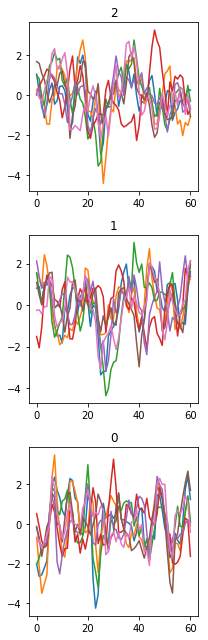

In [534]:
plot.grid_from_array(wrong, elements=9,
                     axis=0, auto_figsize=3)

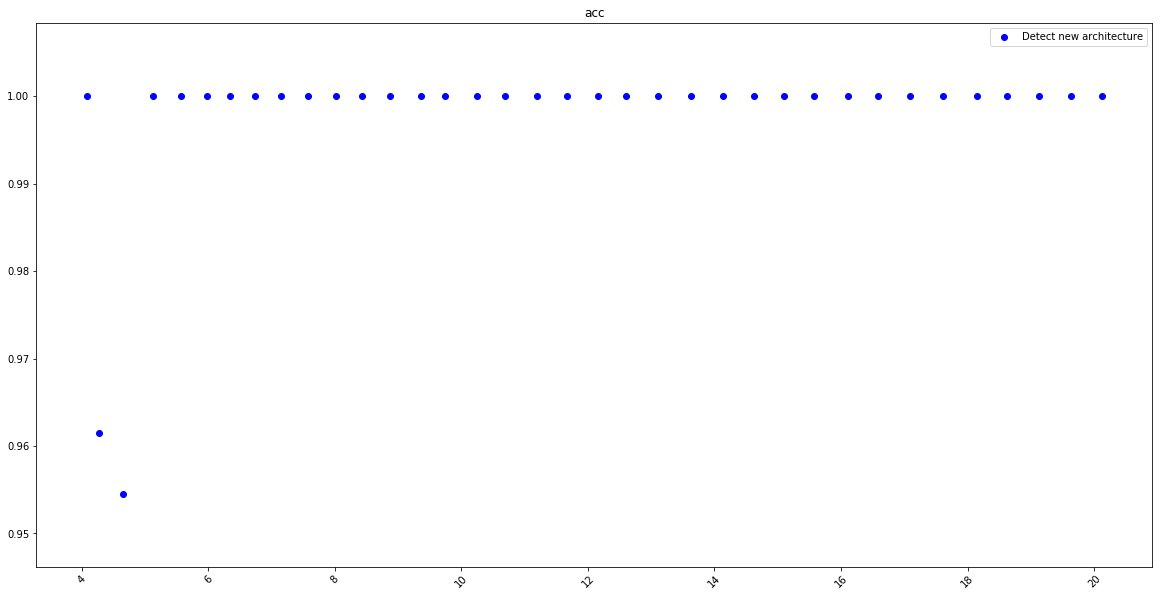

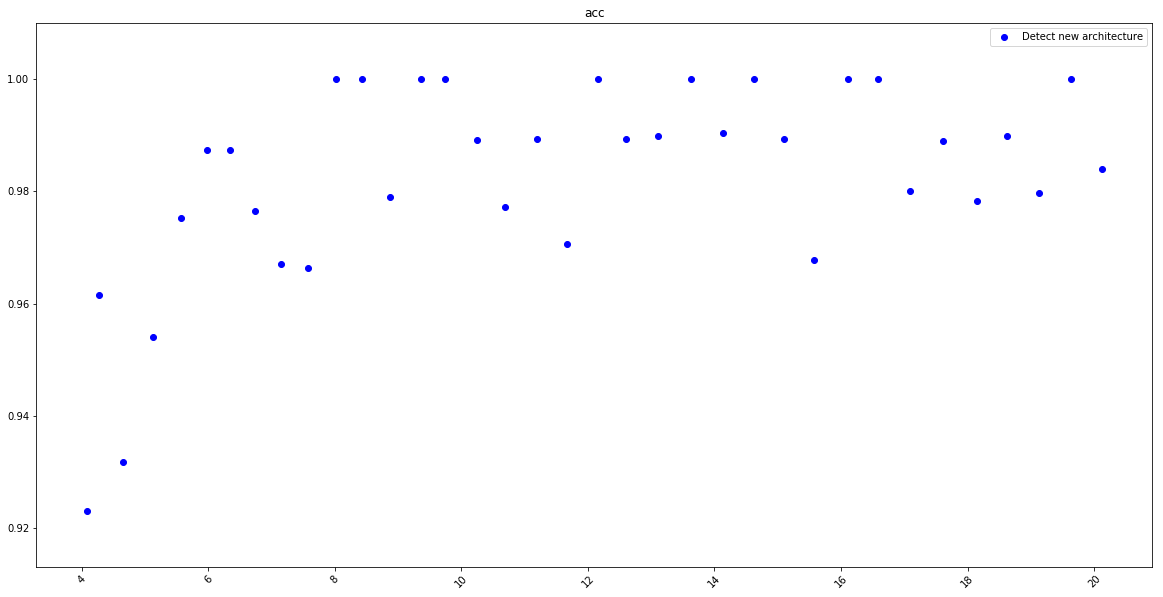

In [542]:
df = dataset.df[(dataset.df.kind == 'from templates') & (dataset.df.amplitude <= 20)]
# df = dataset.df[(dataset.df.kind == 'from templates')]
plot_metric(model, acc, 'acc', df)
plot_metric(baseline, acc, 'acc', df)

## Collided

In [544]:
label = 1
data = sort_data(dataset.get_kind('collided').data)

preds = model.predict(data)
preds_baseline = baseline.predict(data)

# preds = np.squeeze(model.predict(data[:, :, :, np.newaxis]))
print('Proportion of correct predictions', (preds == label).mean())
print('Proportion of correct predictions (baseline)', (preds_baseline == label).mean())

wrong = data[preds != label]

2.509700871175244 98.00180465763057
Proportion of correct predictions 0.9978424224388066
Proportion of correct predictions (baseline) 0.9846737593929024


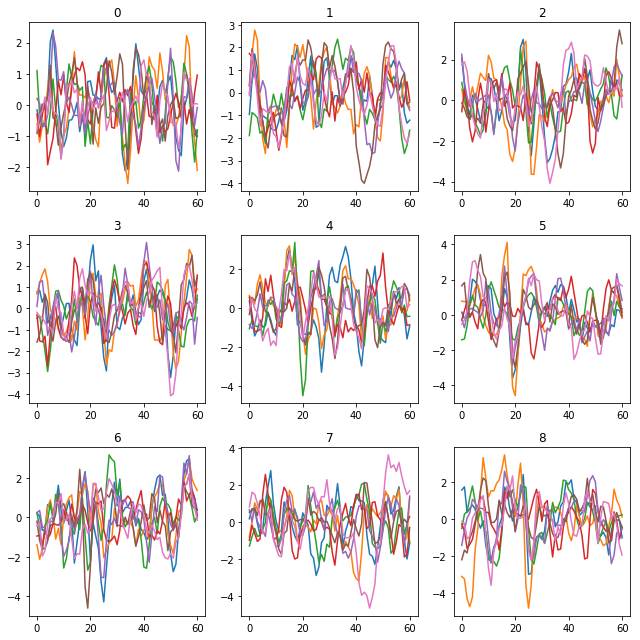

In [549]:
plot.grid_from_array(wrong, elements=range(9), axis=0, auto_figsize=3)

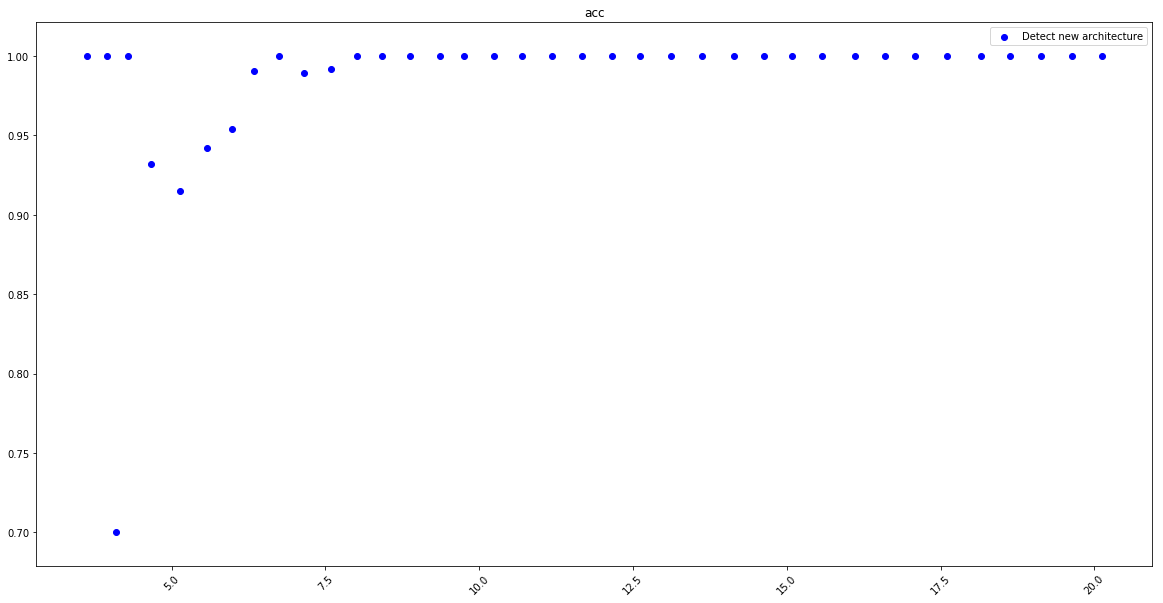

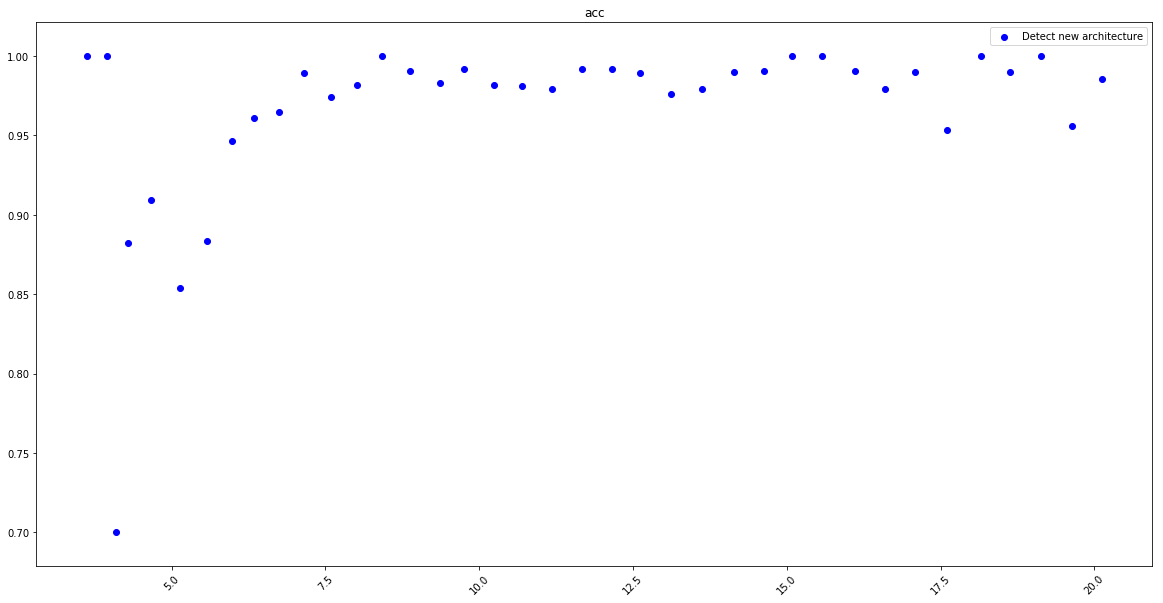

In [550]:
df = dataset.df[(dataset.df.kind == 'collided') & (dataset.df.amplitude <= 20)]
plot_metric(model, acc, 'acc', df)
plot_metric(baseline, acc, 'acc', df)

## Temporally misaligned

In [551]:
label = 0
data = sort_data(dataset.get_kind('temporally misaligned').data)

preds = model.predict(data)
preds_baseline = baseline.predict(data)

# preds = np.squeeze(model.predict_classes(data[:, :, :, np.newaxis]))

print('Proportion of correct predictions', (preds == label).mean())
print('Proportion of correct predictions (baseline)', (preds_baseline == label).mean())

wrong = data[preds != label]

2.463535499447982 73.08762727781841
Proportion of correct predictions 0.9989838987025168
Proportion of correct predictions (baseline) 0.9995310301703924


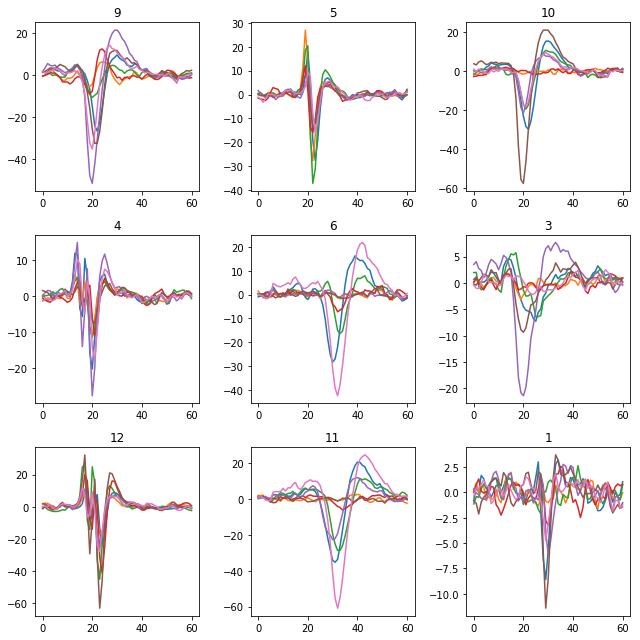

In [552]:
plot.grid_from_array(wrong, elements=9, axis=0, auto_figsize=3)

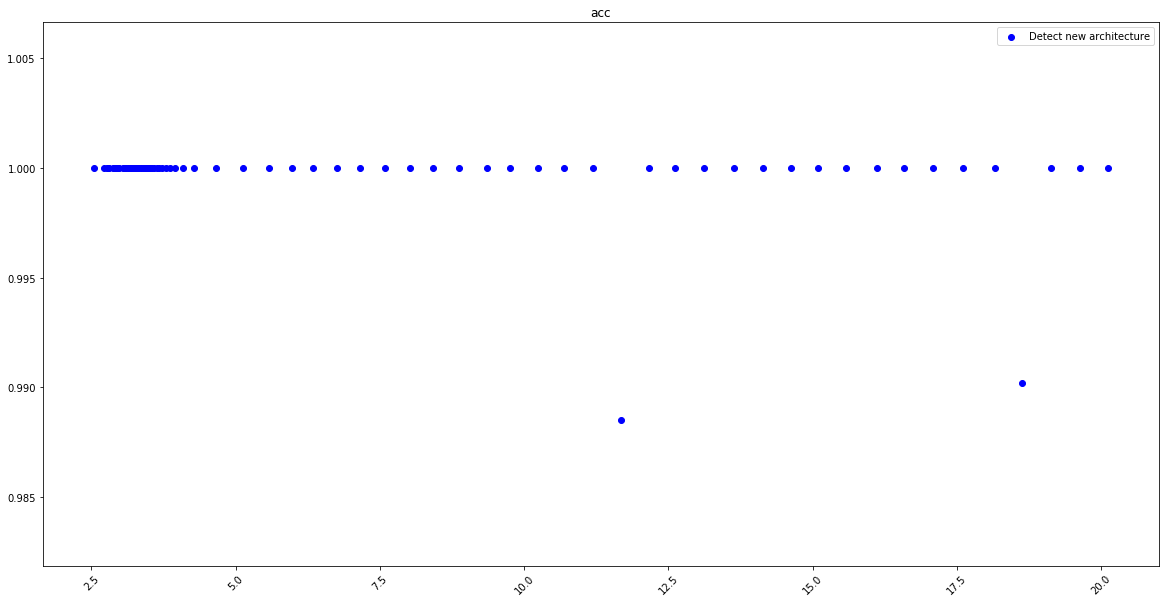

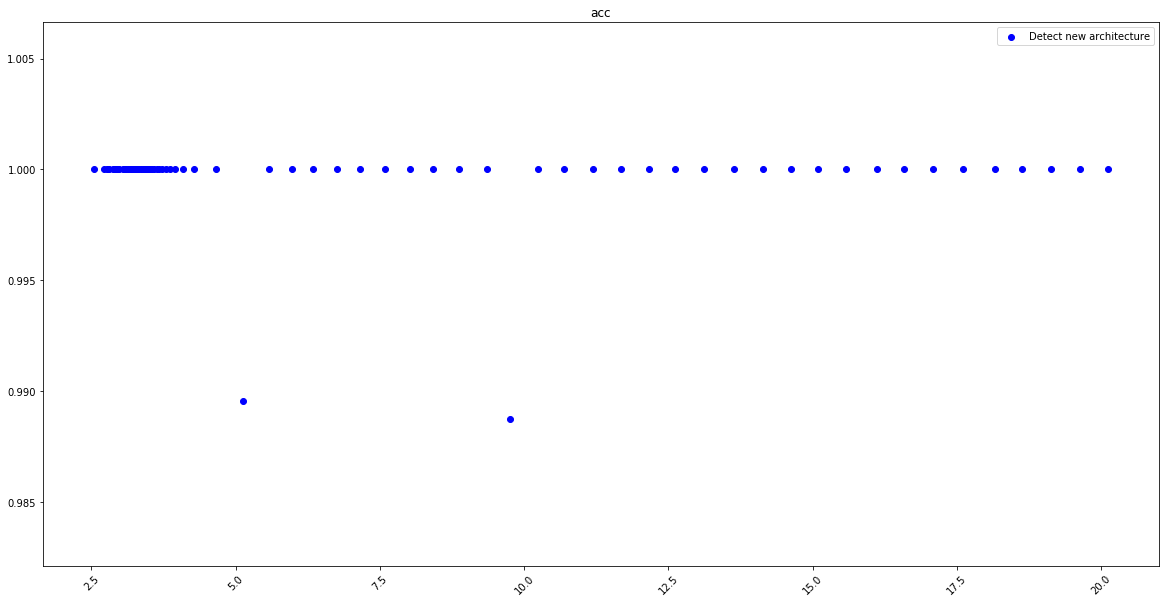

In [553]:
df = dataset.df[(dataset.df.kind == 'temporally misaligned') & (dataset.df.amplitude <= 20)]
plot_metric(model, acc, 'acc', df)
plot_metric(baseline, acc, 'acc', df)

## Spatially misaligned

In [554]:
label = 0
data = sort_data(dataset.get_kind('spatially misaligned').data)

preds = model.predict(data)
preds_baseline = baseline.predict(data)

# preds = np.squeeze(model.predict_classes(data[:, :, :, np.newaxis]))

print('Proportion of correct predictions', (preds == label).mean())
print('Proportion of correct predictions (baseline)', (preds_baseline == label).mean())


wrong = data[preds != label]
wrong.shape

4.021790114366949 73.42488625359154
Proportion of correct predictions 0.3788278564004158
Proportion of correct predictions (baseline) 0.20492524186455585


(7769, 61, 7)

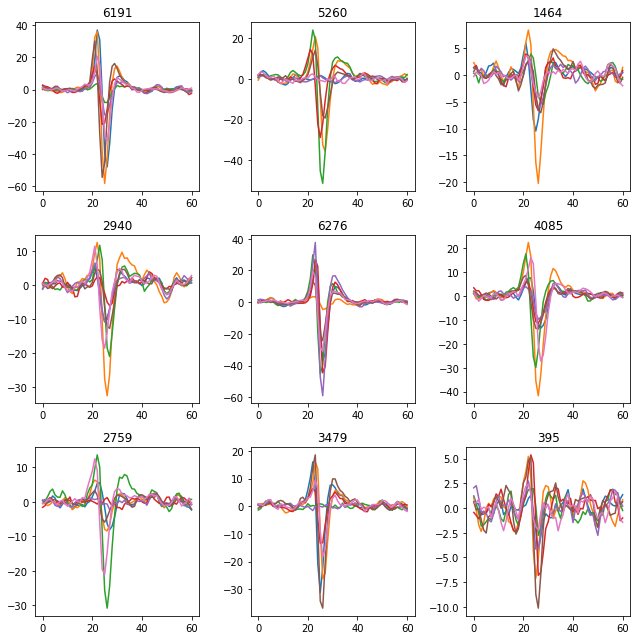

In [555]:
plot.grid_from_array(wrong, elements=9, axis=0, auto_figsize=3)

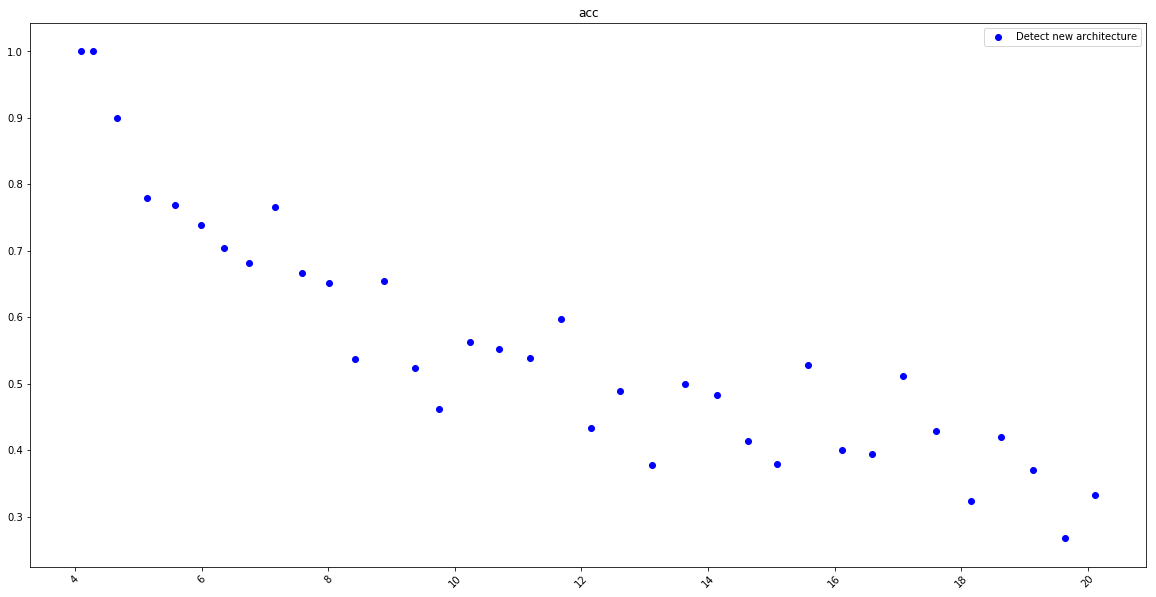

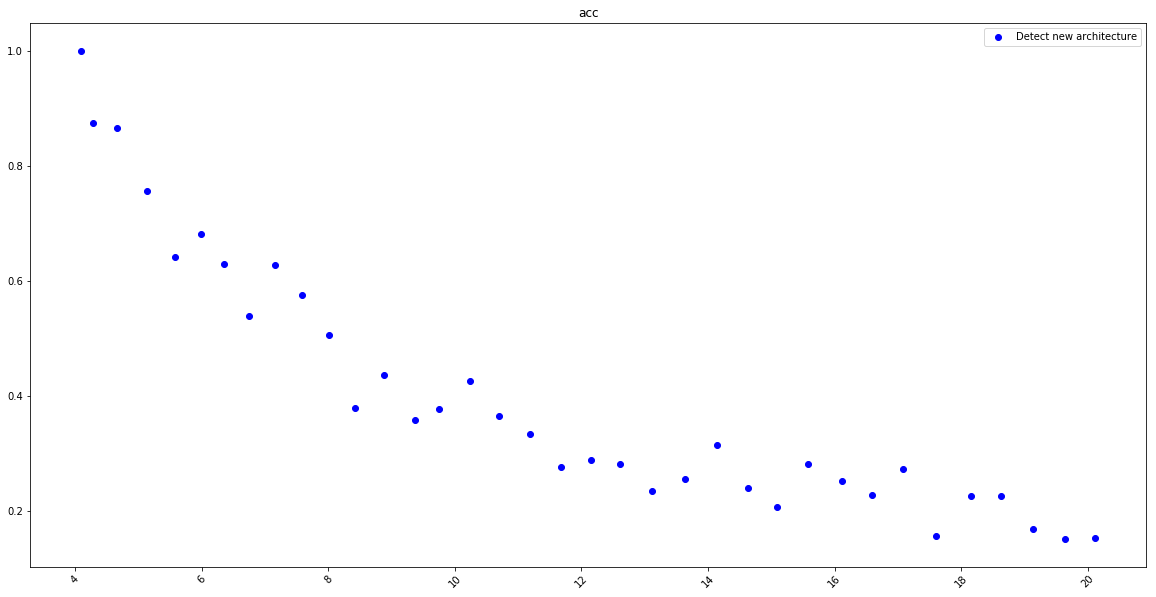

In [556]:
df = dataset.df[(dataset.df.kind == 'spatially misaligned') & (dataset.df.amplitude <= 20)]
plot_metric(model, acc, 'acc', df)
plot_metric(baseline, acc, 'acc', df)

## Noise

In [557]:
label = 0
data = dataset.get_kind('noise').data

preds = model.predict(data)
preds_baseline = baseline.predict(data)

# preds = np.squeeze(model.predict_classes(data[:, :, :, np.newaxis]))
print('Proportion of correct predictions', (preds == label).mean())
print('Proportion of correct predictions (baseline)', (preds_baseline == label).mean())

wrong = data[preds != label]

Proportion of correct predictions 0.9952498020750865
Proportion of correct predictions (baseline) 0.9960831701320888


In [558]:
wrong.shape

(114, 61, 7)

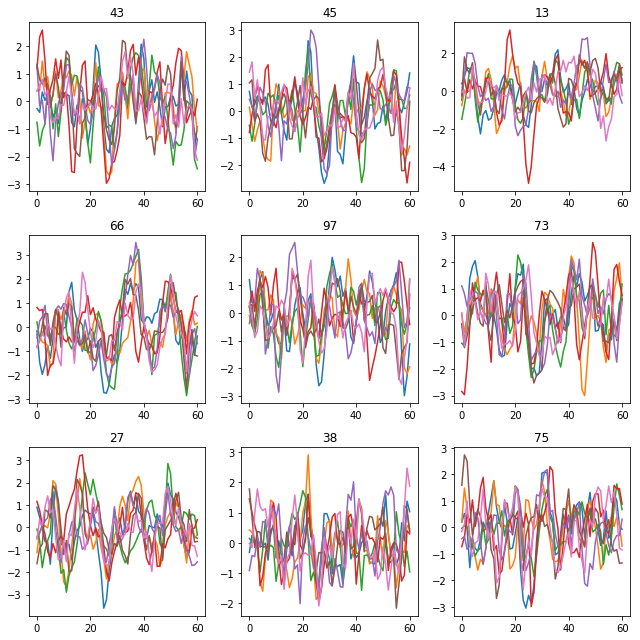

In [559]:
plot.grid_from_array(wrong, elements=9, axis=0, auto_figsize=3)

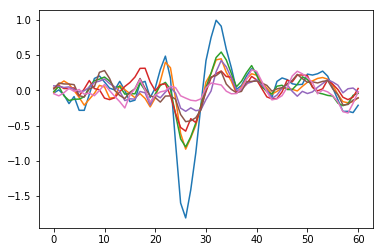

In [560]:
_ = plt.plot(wrong.mean(axis=0))

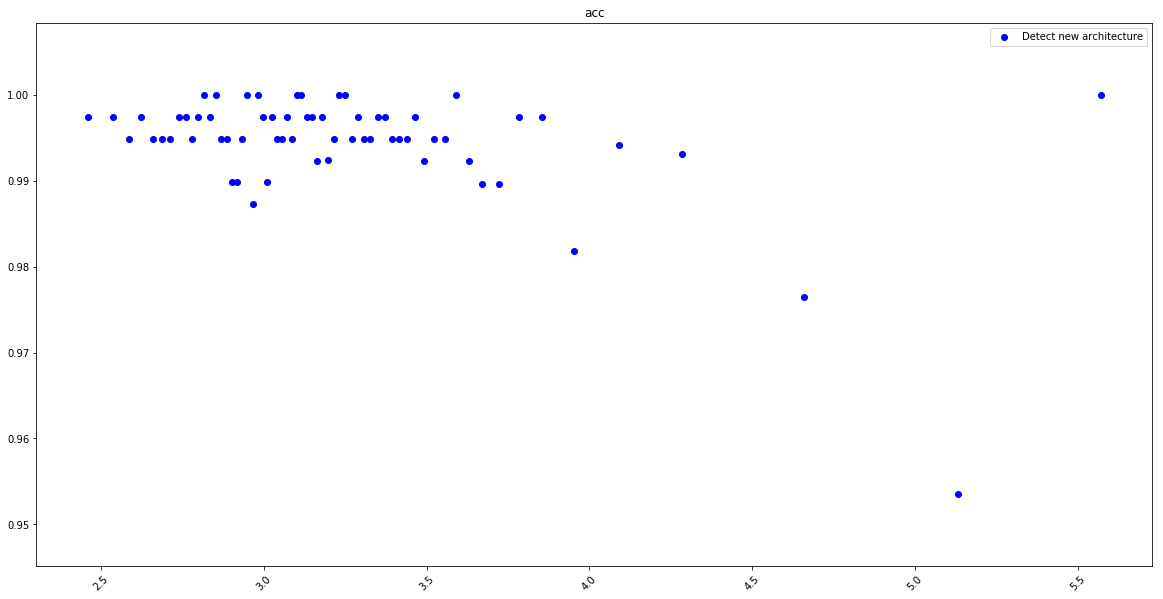

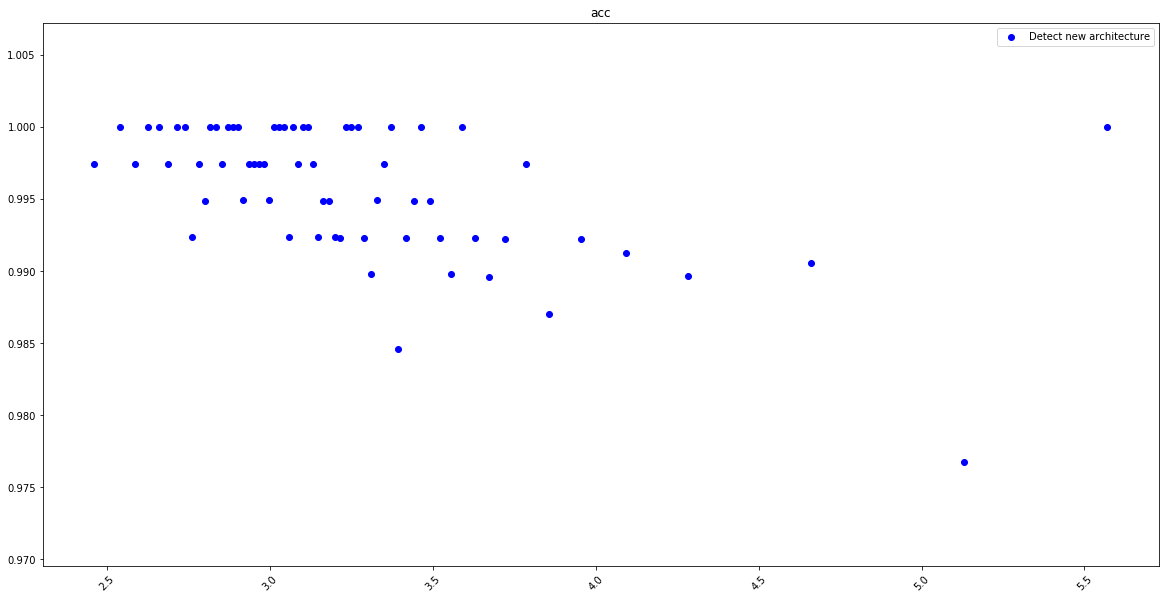

In [561]:
df = dataset.df[(dataset.df.kind == 'noise') & (dataset.df.amplitude <= 20)]
plot_metric(model, acc, 'acc', df)
plot_metric(baseline, acc, 'acc', df)

## Spike detection 49 channels

In [2]:
import yass
# from yass.detect import nnet
from yass import detect
from yass import preprocess

yass.set_config("../../config/gcloud/49/old.yaml", 'sample_output')

(standarized_path,
 standarized_params,
 whiten_filter) = (preprocess
                   .run(if_file_exists='skip'))

res = detect.run(standarized_path, standarized_params, whiten_filter)

# res = nnet.run(standarized_path,
#                standarized_params,
#                 None,
#                 'overwrite',
#                 False)

/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


In [6]:
res[1].shape

(379328, 2)

## Noise evaluation

In [109]:
n_noise = 10000
noise = augment_util.make_noise(n_noise, spatial_sig, temporal_sig)
print('Noise shape:', noise.shape)

Noise shape: (10000, 61, 7)


In [110]:
probas = model.predict_proba(noise)

In [111]:
higher_than_zero = noise[probas > 0.01]
higher_than_one_half = noise[probas > 0.5]

fpr = len(higher_than_one_half)/n_noise

print('{} ({:.4f}) [>0.01], {} ({:.4f})[>0.5]'.format(len(higher_than_zero), len(higher_than_zero)/n_noise,
                                              len(higher_than_one_half), fpr))

4 (0.0004) [>0.01], 0 (0.0000)[>0.5]


In [112]:
plot.grid_from_array(higher_than_one_half,
                     axis=0,
                     auto_figsize=(5, 3),
                     sharey=True,
                     elements=6)

<Figure size 0x0 with 0 Axes>

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


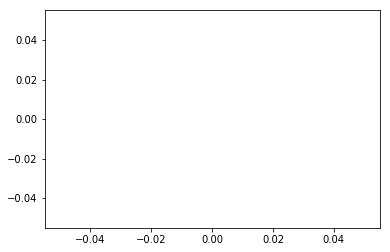

In [113]:
noise_mean_wf = higher_than_one_half.mean(axis=0)
_ = plt.plot(noise_mean_wf)

## Large snippet noise

In [115]:
n_noise = 1
temporal_size = 1000
n_channels = 7

(spatial_sig_large,
 temporal_sig_large) = noise_utils.noise_cov(rec, temporal_size, 61, 80)

In [116]:
noise = augment_util.make_noise(1, spatial_sig_large, temporal_sig_large)[0, :, :]
print('Noise shape:', noise.shape)

Noise shape: (1000, 7)


/home/Edu/yass/src/yass/augment/util.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  noise[:, :, c] = np.matmul(noise[:, :, c], temporal_SIG)


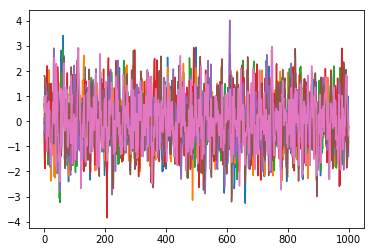

In [117]:
_ = plt.plot(noise)

In [118]:
model.predict_recording(noise)

[array([[ 38,  12],
        [ 53,  14],
        [ 56,  14],
        [ 85,  12],
        [108,  14],
        [247,  12],
        [247,  14],
        [269,  14],
        [305,  14],
        [357,   3],
        [359,   3],
        [404,  14],
        [491,  12],
        [524,  14],
        [525,  12],
        [529,  12],
        [567,  12],
        [605,  12],
        [617,   5],
        [617,  17],
        [624,  14],
        [641,  12],
        [643,  12],
        [679,  12],
        [755,  12],
        [758,  14],
        [871,  12],
        [899,   5],
        [913,  14],
        [940,  12],
        [955,  12]], dtype=int32)]

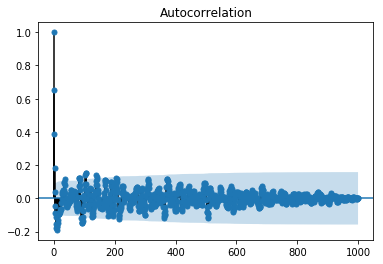

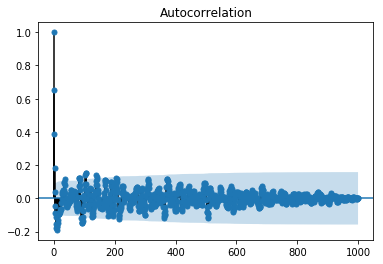

In [123]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(noise[0, :, 4])

In [132]:
import yaml
from yass import detect
from yass.detect import nnet

params = {'data_order': 'samples', 'dtype': noise.dtype, 'n_channels': 49}
noise.tofile('/tmp/noise.bin')

with open('/tmp/noise.yaml', 'w') as f:
        yaml.dump(params, f)

In [133]:
scores, clear, spikes_all = detect.run('/tmp/noise.bin', '/tmp/noise.yaml',
                                       '/home/Edu/data/retinal/sample_output/preprocess/whitening.npy',
                                      function=nnet.run)

FileNotFoundError: [Errno 2] No such file or directory: '/home/Edu/data/retinal/tmp/detect'

In [ ]:
spikes_all.shape

## Misclassified noise with varying amplitudes

In [39]:
noise_df = dataset.get_kind('noise', units_per_bin=0.5).df

# add labels
_ = {'noise': 0}

noise_df['label'] = noise_df.kind.replace(_)

noise_df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group,label
0,"[[-0.5167180328667593, 0.3528625423030752, -1....",2.287116,noise,3.743737,2.501,4.218,0
1,"[[-0.9781039028627837, -0.7824938165579068, -0...",3.532306,noise,5.018683,5.705,5.071,0
2,"[[-1.5115761869056192, -1.301904977423462, -1....",2.545152,noise,4.946535,2.682,5.071,0
3,"[[0.1359663075964111, -0.920120209009032, -0.1...",1.996428,noise,3.885345,2.501,4.218,0
4,"[[2.0107593248581606, 2.217113874043089, 1.339...",2.234238,noise,4.033950,2.501,4.218,0


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


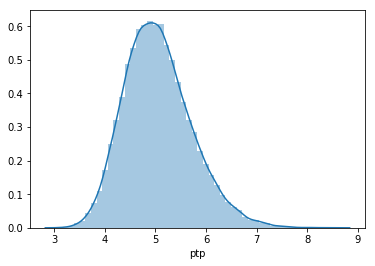

In [40]:
sns.distplot(noise_df.ptp)

In [41]:
def prop(preds, group):
    return (1 - (preds == group.label).mean())

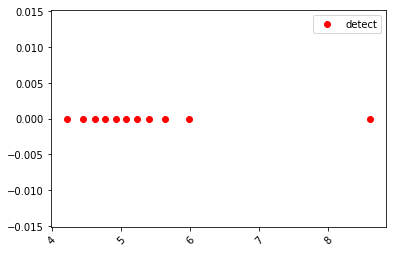

In [42]:
x, y = evaluate.compute_per_group(noise_df, 'ptp_group',
                                  model.predict, prop)

# plot results
# label=model.model_name
_ = plt.scatter(x, y, color='r', label='detect')

_ = plt.legend()
_ = plt.xticks(rotation=45)

## Predict on recordings

## Metrics vs SNR

In [97]:
def mean_tp_prob(preds, group):
    real_ones = group.label.values == 1
    return preds[real_ones].mean()

def mean_tn_prob(preds, group):
    real_zeros = group.label.values == 0
    return preds[real_zeros].mean()

def acc(preds, group):
    return (preds == group.label.values).mean()

def fpr(preds, group):
    real_zeros = group.label.values == 0
    return (preds[real_zeros] == 1).mean()

def fnr(preds, group):
    real_ones = group.label.values == 1
    return (preds[real_ones] == 0).mean()

def tpr(preds, group):
    real_ones = group.label.values == 1
    return (preds[real_ones] == 1).mean()

def tnr(preds, group):
    real_zeros = group.label.values == 0
    return (preds[real_zeros] == 0).mean()

def accuracy(preds, group):
    return metrics.accuracy_score(group.label, preds)

In [98]:
from functools import partial

def predict_w_threshold(x, threshold):
    return model.predict_proba(x) > threshold

predict_ = partial(predict_w_threshold, threshold=THRESHOLD)
# predict_ = model.predict_proba

In [538]:
def plot_metric(model, metric, title, df):
    x, y = evaluate.compute_per_group(df,
                         'amplitude_group',
                         model.predict_classes if hasattr(model, 'predict_classes') else model.predict,
                         metric)    

    plt.figure(figsize=(20, 10))

    _ = plt.scatter(x, y, color='b', label='Detect new architecture')
    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xticks(rotation=45)